In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def fuse_hls_modis_heat_stress(hls_files, modis_files, admin_boundary):
    """
    融合 HLS 和 MODIS 數據，提高可信度
    """
    
    results = []
    
    for hls_file, modis_file in zip(hls_files, modis_files):
        # 讀取數據
        hls_gdf = gpd.read_file(hls_file)
        modis_gdf = gpd.read_file(modis_file)
        
        # 提取年份
        year = hls_file.split('_')[-1][:4]
        
        # 合併（假設行政區名稱相同）
        merged = hls_gdf.merge(
            modis_gdf[['TNAME', 'p90']], 
            on='TNAME', 
            suffixes=('_hls', '_modis')
        )
        
        # 計算差異和可信度
        merged['lst_diff'] = abs(merged['p90_hls'] - merged['p90_modis'])
        merged['confidence'] = np.where(
            merged['lst_diff'] < 3, '高',
            np.where(merged['lst_diff'] < 5, '中', '低')
        )
        
        # 加權融合（HLS 0.6, MODIS 0.4）
        merged['lst_fused'] = (
            0.6 * merged['p90_hls'] + 
            0.4 * merged['p90_modis']
        )
        
        # 根據可信度調整權重
        low_conf_mask = merged['confidence'] == '低'
        merged.loc[low_conf_mask, 'lst_fused'] = (
            0.3 * merged.loc[low_conf_mask, 'p90_hls'] + 
            0.7 * merged.loc[low_conf_mask, 'p90_modis']
        )
        
        merged['year'] = year
        results.append(merged)
    
    # 基於融合數據計算熱壓力
    combined = pd.concat(results, ignore_index=True)
    
    return combined


def calculate_comprehensive_heat_index(lst_files):
    """
    綜合熱壓力指數 (Comprehensive Heat Stress Index, CHSI)
    
    考慮：
    1. 絕對溫度
    2. 年際變化趨勢
    3. 相對熱島強度
    4. 極端值頻率
    """
    
    # 讀取所有年份數據
    all_data = []
    for file in lst_files:
        gdf = gpd.read_file(file)
        year = int(file.split('_')[-1][:4])
        gdf['year'] = year
        all_data.append(gdf)
    
    combined = pd.concat(all_data, ignore_index=True)
    
    # 按行政區分組計算
    results = []
    
    for town in combined['TNAME'].unique():
        town_data = combined[combined['TNAME'] == town]
        
        # 1. 平均溫度分數 (0-40分)
        avg_temp = town_data['p90'].mean()
        temp_score = np.clip((avg_temp - 25) * 2, 0, 40)
        
        # 2. 升溫趨勢分數 (0-30分)
        years = town_data['year'].values
        temps = town_data['p90'].values
        if len(years) > 1:
            trend = np.polyfit(years, temps, 1)[0]  # 線性趨勢
            trend_score = np.clip(trend * 30, 0, 30)
        else:
            trend_score = 0
        
        # 3. 熱島強度分數 (0-30分)
        regional_baseline = combined['p90'].quantile(0.1)
        uhi = avg_temp - regional_baseline
        uhi_score = np.clip(uhi * 5, 0, 30)
        
        # 綜合分數
        chsi = temp_score + trend_score + uhi_score
        
        # 分級
        if chsi < 30:
            risk_level = '低風險'
        elif chsi < 50:
            risk_level = '中風險'
        elif chsi < 70:
            risk_level = '高風險'
        else:
            risk_level = '極高風險'
        
        results.append({
            'TNAME': town,
            'avg_temp': avg_temp,
            'temp_trend': trend if len(years) > 1 else 0,
            'uhi_intensity': uhi,
            'temp_score': temp_score,
            'trend_score': trend_score,
            'uhi_score': uhi_score,
            'CHSI': chsi,
            'risk_level': risk_level
        })
    
    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values('CHSI', ascending=False)
    
    return result_df

def export_heat_index_to_geojson(heat_index_df, admin_boundary_path, output_path):
    """
    將熱壓力指數 DataFrame 合併行政區邊界，輸出 GeoJSON
    
    Parameters:
    - heat_index_df: 包含 TOWNNAME 和各種分數的 DataFrame
    - admin_boundary_path: 行政區邊界 GeoJSON 路徑
    - output_path: 輸出的 GeoJSON 路徑
    """
    
    # 讀取行政區邊界（帶有 geometry）
    admin = gpd.read_file(admin_boundary_path)
    
    # 確保欄位名稱一致
    print(f"Admin 欄位: {admin.columns.tolist()}")
    print(f"Heat Index 欄位: {heat_index_df.columns.tolist()}")
    
    # 合併（保留 geometry）
    result = admin.merge(
        heat_index_df, 
        on='TNAME',  # 或你的行政區名稱欄位
        how='left'  # 保留所有行政區，即使沒有數據也顯示
    )
    
    # 檢查合併結果
    print(f"\n合併前: {len(admin)} 個行政區")
    print(f"合併後: {len(result)} 個行政區")
    print(f"有數據的: {result['CHSI'].notna().sum()} 個")
    
    # 輸出 GeoJSON
    result.to_file(output_path, driver='GeoJSON')
    print(f"\n✅ 已輸出至: {output_path}")
    
    return result


/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/3934750842.py:59: UserWarning: Glyph 33836 (\N{CJK UNIFIED IDEOGRAPH-842C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/3934750842.py:59: UserWarning: Glyph 33775 (\N{CJK UNIFIED IDEOGRAPH-83EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/3934750842.py:59: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/3934750842.py:59: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/3934750842.py:59: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl

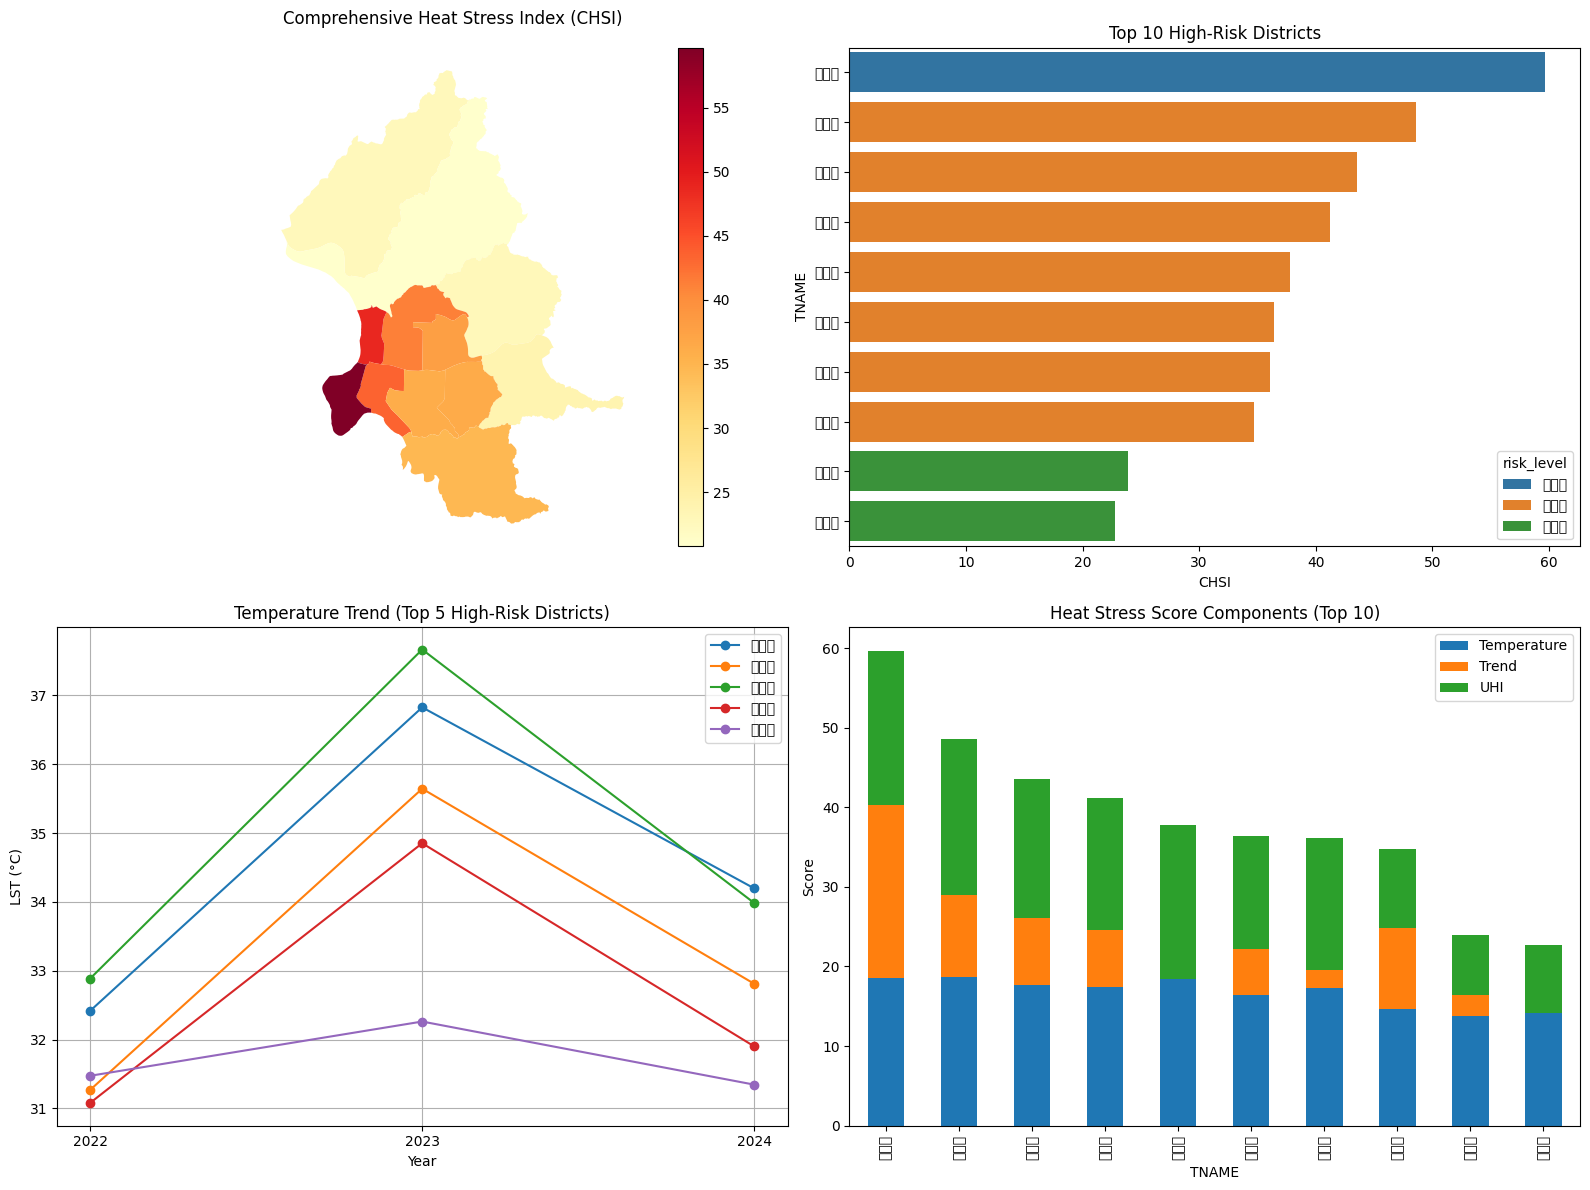

=== Heat Environment Stress Analysis Report ===

Number of Extreme High-Risk Districts: 0
Average Temperature: 32.21°C
Average Warming Trend: 0.184°C/year

Top 5 High-Risk Districts:
  TNAME       CHSI risk_level
9   萬華區  59.688825        高風險
4   大同區  48.627003        中風險
7   中正區  43.537625        中風險
3   中山區  41.193068        中風險
5   松山區  37.828861        中風險


In [5]:

ADMIN_BOUNDARY_FILE = '臺北市區界圖_20220915/G97_A_CADIST_P.shp'

# Step 1: Fuse HLS and MODIS
hls_files = [
    'output/result_lst_admin_2022251.geojson',
    'output/result_lst_admin_2023190.geojson',
    'output/result_lst_admin_2024185.geojson'
]

modis_files = [
    'output/result_mod11a2_admin_2022257.geojson',
    'output/result_mod11a2_admin_2023193.geojson',
    'output/result_mod11a2_admin_2024193.geojson'
]

fused_data = fuse_hls_modis_heat_stress(hls_files, modis_files, ADMIN_BOUNDARY_FILE)

# Step 2: Calculate Comprehensive Heat Stress Index
heat_index = calculate_comprehensive_heat_index(hls_files)

# Step 3: Temporal Analysis
temporal_analysis = fused_data.groupby(['TNAME', 'year']).agg({
    'lst_fused': ['mean', 'std'],
    'confidence': lambda x: (x == '高').sum() / len(x)
}).reset_index()

# Step 4: Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 4.1 Heat Stress Index Map
admin = gpd.read_file(ADMIN_BOUNDARY_FILE)
admin = admin.merge(heat_index[['TNAME', 'CHSI', 'risk_level']], on='TNAME')
admin.plot(column='CHSI', cmap='YlOrRd', legend=True, ax=axes[0,0])
axes[0,0].set_title('Comprehensive Heat Stress Index (CHSI)')
axes[0,0].axis('off')

# 4.2 Top 10 High-Risk Districts
top10 = heat_index.nlargest(10, 'CHSI')
sns.barplot(data=top10, x='CHSI', y='TNAME', hue='risk_level', ax=axes[0,1])
axes[0,1].set_title('Top 10 High-Risk Districts')

# 4.3 Temperature Trend for Top 5 High-Risk Districts
for town in heat_index.nlargest(5, 'CHSI')['TNAME']:
    town_data = fused_data[fused_data['TNAME'] == town]
    axes[1,0].plot(town_data['year'], town_data['lst_fused'], marker='o', label=town)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('LST (°C)')
axes[1,0].set_title('Temperature Trend (Top 5 High-Risk Districts)')
axes[1,0].legend()
axes[1,0].grid(True)

# 4.4 Score Components (Top 10)
score_components = heat_index[['TNAME', 'temp_score', 'trend_score', 'uhi_score']].head(10)
score_components.set_index('TNAME').plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Heat Stress Score Components (Top 10)')
axes[1,1].set_ylabel('Score')
axes[1,1].legend(['Temperature', 'Trend', 'UHI'])

plt.tight_layout()
plt.savefig('heat_stress_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 5: Output Report
heat_index.to_csv('heat_stress_report.csv', index=False, encoding='utf-8-sig')
admin.to_file('heat_stress_map.geojson', driver='GeoJSON')

print("=== Heat Environment Stress Analysis Report ===")
print(f"\nNumber of Extreme High-Risk Districts: {(heat_index['risk_level'] == '極高風險').sum()}")
print(f"Average Temperature: {fused_data['lst_fused'].mean():.2f}°C")
print(f"Average Warming Trend: {heat_index['temp_trend'].mean():.3f}°C/year")
print("\nTop 5 High-Risk Districts:")
print(heat_index[['TNAME', 'CHSI', 'risk_level']].head())

In [21]:

# 使用範例
heat_index_gdf = export_heat_index_to_geojson(
    heat_index_df=heat_index,
    admin_boundary_path=ADMIN_BOUNDARY_FILE,  # 你的原始行政區邊界
    output_path='./output/taipei_fused_HLS_heat_stress_index.geojson'
)

Admin 欄位: ['AREA', 'PERF_ID', 'COUN_ID', 'CPID', 'CPTID', 'NPID', 'NPTID', 'PNAME', 'TNAME', 'PTNAME', 'TM2_MAX_X', 'TM2_MAX_Y', 'TM2_MIN_X', 'TM2_MIN_Y', 'MAX_X', 'MAX_Y', 'MIN_X', 'MIN_Y', 'geometry']
Heat Index 欄位: ['TNAME', 'avg_temp', 'temp_trend', 'uhi_intensity', 'temp_score', 'trend_score', 'uhi_score', 'CHSI', 'risk_level']

合併前: 12 個行政區
合併後: 12 個行政區
有數據的: 12 個

✅ 已輸出至: ./output/taipei_fused_HLS_heat_stress_index.geojson


# NDVI

In [19]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fuse_hls_modis_ndvi(hls_files, modis_files):
    """
    融合 HLS 和 MODIS 的 NDVI 數據，提高可信度
    
    Parameters:
    - hls_files: HLS NDVI 結果檔案列表
    - modis_files: MODIS NDVI 結果檔案列表
    
    Returns:
    - combined: 融合後的 DataFrame
    """
    
    results = []
    
    for hls_file, modis_file in zip(hls_files, modis_files):
        # 讀取數據
        hls_gdf = gpd.read_file(hls_file)
        modis_gdf = gpd.read_file(modis_file)
        
        # 提取年份
        year = hls_file.split('_')[-1][:4]
        
        # 合併（假設行政區名稱相同）
        merged = hls_gdf.merge(
            modis_gdf[['TNAME', 'mean']],  # 或你的 NDVI 欄位名稱
            on='TNAME', 
            suffixes=('_hls', '_modis')
        )
        
        # 計算差異和可信度
        # NDVI 範圍 -1 to 1，差異閾值需要調整
        merged['ndvi_diff'] = abs(merged['mean_hls'] - merged['mean_modis'])
        merged['confidence'] = np.where(
            merged['ndvi_diff'] < 0.05, '高',      # NDVI 差異 < 0.05 → 高可信度
            np.where(merged['ndvi_diff'] < 0.10, '中', '低')  # 0.05-0.10 → 中
        )
        
        # 加權融合（HLS 0.6, MODIS 0.4）
        merged['ndvi_fused'] = (
            0.8 * merged['mean_hls'] + 
            0.2 * merged['mean_modis']
        )
        
        # 根據可信度調整權重
        low_conf_mask = merged['confidence'] == '低'
        merged.loc[low_conf_mask, 'ndvi_fused'] = (
            0.3 * merged.loc[low_conf_mask, 'mean_hls'] + 
            0.7 * merged.loc[low_conf_mask, 'mean_modis']
        )
        
        merged['year'] = year
        results.append(merged)
    
    # 基於融合數據
    combined = pd.concat(results, ignore_index=True)
    
    print(f"✅ NDVI 融合完成！")
    print(f"總筆數: {len(combined)}")
    print(f"平均 NDVI (HLS): {combined['mean_hls'].mean():.3f}")
    print(f"平均 NDVI (MODIS): {combined['mean_modis'].mean():.3f}")
    print(f"平均 NDVI (融合): {combined['ndvi_fused'].mean():.3f}")
    print(f"\n可信度分布:")
    print(combined['confidence'].value_counts())
    
    return combined


def calculate_vegetation_index(ndvi_files):
    """
    計算植被綜合指數 (Comprehensive Vegetation Index, CVI)
    
    考慮：
    1. 平均 NDVI 水平
    2. NDVI 變化趨勢
    3. 植被覆蓋等級
    """
    
    # 讀取所有年份數據
    all_data = []
    for file in ndvi_files:
        gdf = gpd.read_file(file)
        year = int(file.split('_')[-1][:4])
        gdf['year'] = year
        all_data.append(gdf)
    
    combined = pd.concat(all_data, ignore_index=True)
    
    # 按行政區分組計算
    results = []
    
    for town in combined['TNAME'].unique():
        town_data = combined[combined['TNAME'] == town]
        
        # 1. 平均 NDVI
        avg_ndvi = town_data['mean'].mean()
        
        # 2. NDVI 變化趨勢
        years = town_data['year'].values.astype(int)
        ndvi_values = town_data['mean'].values.astype(float)
        if len(years) > 1:
            trend = np.polyfit(years, ndvi_values, 1)[0]  # 線性趨勢
        else:
            trend = 0
        
        # 3. 植被覆蓋等級（基於 NDVI）
        if avg_ndvi < 0.2:
            vegetation_level = '極低植被'
            veg_score = 1
        elif avg_ndvi < 0.3:
            vegetation_level = '低植被'
            veg_score = 2
        elif avg_ndvi < 0.4:
            vegetation_level = '中植被'
            veg_score = 3
        elif avg_ndvi < 0.5:
            vegetation_level = '高植被'
            veg_score = 4
        else:
            vegetation_level = '極高植被'
            veg_score = 5
        
        # 4. 趨勢評估
        if trend < -0.01:
            trend_status = '顯著下降'
            trend_concern = '高'
        elif trend < -0.005:
            trend_status = '輕微下降'
            trend_concern = '中'
        elif trend > 0.005:
            trend_status = '上升'
            trend_concern = '低'
        else:
            trend_status = '穩定'
            trend_concern = '低'
        
        results.append({
            'TNAME': town,
            'avg_ndvi': round(avg_ndvi, 3),
            'ndvi_trend': round(trend, 5),
            'vegetation_level': vegetation_level,
            'veg_score': veg_score,
            'trend_status': trend_status,
            'trend_concern': trend_concern
        })
    
    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values('avg_ndvi', ascending=True)  # 低植被在前
    
    return result_df


def export_ndvi_to_geojson(ndvi_df, admin_boundary_path, output_path):
    """
    將 NDVI 指數 DataFrame 合併行政區邊界，輸出 GeoJSON
    """
    
    # 讀取行政區邊界（帶有 geometry）
    admin = gpd.read_file(admin_boundary_path)
    
    # 確保欄位名稱一致
    print(f"Admin 欄位: {admin.columns.tolist()}")
    print(f"NDVI 欄位: {ndvi_df.columns.tolist()}")
    
    # 合併（保留 geometry）
    result = admin.merge(
        ndvi_df, 
        on='TNAME',
        how='left'
    )
    
    # 檢查合併結果
    print(f"\n合併前: {len(admin)} 個行政區")
    print(f"合併後: {len(result)} 個行政區")
    print(f"有數據的: {result['avg_ndvi'].notna().sum()} 個")
    
    # 輸出 GeoJSON
    result.to_file(output_path, driver='GeoJSON')
    print(f"\n✅ 已輸出至: {output_path}")
    
    return result


# ===== 完整分析流程 =====

def complete_ndvi_analysis(hls_files, modis_files, admin_boundary_path, output_dir='output'):
    """
    完整的 NDVI 融合與分析流程
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("="*60)
    print("開始 NDVI 融合分析...")
    print("="*60)
    
    # Step 1: 融合 HLS 和 MODIS NDVI
    fused_ndvi = fuse_hls_modis_ndvi(hls_files, modis_files)
    
    # 儲存融合結果
    fused_output = f'{output_dir}/fused_ndvi_data.csv'
    fused_ndvi.to_csv(fused_output, index=False, encoding='utf-8-sig')
    print(f"\n✅ 融合數據已儲存: {fused_output}")
    
    # Step 2: 計算植被指數（基於融合後的數據）
    # 先將融合數據轉成類似原始格式
    vegetation_index = calculate_vegetation_index_from_fused(fused_ndvi)
    
    # Step 3: 輸出 GeoJSON
    result_gdf = export_ndvi_to_geojson(
        vegetation_index, 
        admin_boundary_path,
        f'{output_dir}/vegetation_index.geojson'
    )
    
    # Step 4: 統計報告
    print("\n" + "="*60)
    print("NDVI 分析報告")
    print("="*60)
    print(f"平均 NDVI: {vegetation_index['avg_ndvi'].mean():.3f}")
    print(f"最低 NDVI 行政區: {vegetation_index.iloc[0]['TNAME']} ({vegetation_index.iloc[0]['avg_ndvi']:.3f})")
    print(f"最高 NDVI 行政區: {vegetation_index.iloc[-1]['TNAME']} ({vegetation_index.iloc[-1]['avg_ndvi']:.3f})")
    print(f"\n植被等級分布:")
    print(vegetation_index['vegetation_level'].value_counts())
    print(f"\n趨勢狀態分布:")
    print(vegetation_index['trend_status'].value_counts())
    
    # Step 5: 視覺化
    visualize_ndvi_analysis(result_gdf, fused_ndvi, vegetation_index, output_dir)
    
    return result_gdf, fused_ndvi, vegetation_index


def calculate_vegetation_index_from_fused(fused_ndvi):
    """
    從融合後的 NDVI 數據計算植被指數
    """
    results = []
    
    for town in fused_ndvi['TNAME'].unique():
        town_data = fused_ndvi[fused_ndvi['TNAME'] == town]
        
        # 使用融合後的 NDVI
        avg_ndvi = town_data['ndvi_fused'].mean()
        
        # 計算趨勢
        years = town_data['year'].values.astype(int)
        ndvi_values = town_data['ndvi_fused'].values
        if len(years) > 1:
            trend = np.polyfit(years, ndvi_values, 1)[0]
        else:
            trend = 0
        
        # 植被等級
        if avg_ndvi < 0.2:
            vegetation_level = '極低植被'
            veg_score = 1
        elif avg_ndvi < 0.3:
            vegetation_level = '低植被'
            veg_score = 2
        elif avg_ndvi < 0.4:
            vegetation_level = '中植被'
            veg_score = 3
        elif avg_ndvi < 0.5:
            vegetation_level = '高植被'
            veg_score = 4
        else:
            vegetation_level = '極高植被'
            veg_score = 5
        
        # 趨勢狀態
        if trend < -0.01:
            trend_status = '顯著下降'
            trend_concern = '高'
        elif trend < -0.005:
            trend_status = '輕微下降'
            trend_concern = '中'
        elif trend > 0.005:
            trend_status = '上升'
            trend_concern = '低'
        else:
            trend_status = '穩定'
            trend_concern = '低'
        
        results.append({
            'TNAME': town,
            'avg_ndvi': round(avg_ndvi, 3),
            'ndvi_trend': round(trend, 5),
            'vegetation_level': vegetation_level,
            'veg_score': veg_score,
            'trend_status': trend_status,
            'trend_concern': trend_concern
        })
    
    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values('avg_ndvi', ascending=True)
    
    return result_df


def visualize_ndvi_analysis(result_gdf, fused_ndvi, vegetation_index, output_dir):
    """
    視覺化 NDVI 分析結果
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. NDVI 空間分布圖
    result_gdf.plot(column='avg_ndvi', cmap='YlGn', legend=True,
                    ax=axes[0,0], edgecolor='black', linewidth=0.5)
    axes[0,0].set_title('平均 NDVI 空間分布', fontsize=14, fontweight='bold')
    axes[0,0].axis('off')
    
    # 2. 植被等級分布
    veg_counts = vegetation_index['vegetation_level'].value_counts()
    colors = ['#d73027', '#fc8d59', '#fee090', '#91cf60', '#1a9850']
    axes[0,1].barh(range(len(veg_counts)), veg_counts.values, color=colors)
    axes[0,1].set_yticks(range(len(veg_counts)))
    axes[0,1].set_yticklabels(veg_counts.index)
    axes[0,1].set_xlabel('行政區數量')
    axes[0,1].set_title('植被等級分布', fontsize=14, fontweight='bold')
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # 3. NDVI 時間趨勢（Top 5 低植被區）
    low_veg_towns = vegetation_index.nsmallest(5, 'avg_ndvi')['TNAME']
    for town in low_veg_towns:
        town_data = fused_ndvi[fused_ndvi['TNAME'] == town]
        axes[1,0].plot(town_data['year'], town_data['ndvi_fused'], 
                       marker='o', label=town, linewidth=2)
    axes[1,0].set_xlabel('年份', fontsize=12)
    axes[1,0].set_ylabel('NDVI', fontsize=12)
    axes[1,0].set_title('低植被區 NDVI 趨勢', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. HLS vs MODIS 散點圖
    scatter = axes[1,1].scatter(
        fused_ndvi['mean_hls'], 
        fused_ndvi['mean_modis'],
        c=fused_ndvi['ndvi_diff'], 
        cmap='RdYlGn_r', 
        s=100, 
        alpha=0.6, 
        edgecolors='black'
    )
    axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='1:1 線')
    axes[1,1].set_xlabel('HLS NDVI', fontsize=12)
    axes[1,1].set_ylabel('MODIS NDVI', fontsize=12)
    axes[1,1].set_title('HLS vs MODIS NDVI 比較', fontsize=14, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,1], label='差異')
    
    plt.tight_layout()
    output_path = f'{output_dir}/ndvi_analysis.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ 視覺化圖表已儲存: {output_path}")
    plt.close()


# ===== 使用範例 =====

if __name__ == '__main__':
    
    ADMIN_BOUNDARY_FILE = '臺北市區界圖_20220915/G97_A_CADIST_P.shp'
    
    # HLS NDVI 檔案
    hls_ndvi_files = [
        'output/result_ndvi_admin_2022251.geojson',
        'output/result_ndvi_admin_2023190.geojson',
        'output/result_ndvi_admin_2024185.geojson'
    ]
    
    # MODIS NDVI 檔案（你需要先產生這些）
    modis_ndvi_files = [
        'output/result_mod13q1_admin_2022257.geojson',  # MOD13Q1 或 MOD13A2
        'output/result_mod13q1_admin_2023193.geojson',
        'output/result_mod13q1_admin_2024193.geojson'
    ]
    
    # 執行完整分析
    result_gdf, fused_ndvi, vegetation_index = complete_ndvi_analysis(
        hls_files=hls_ndvi_files,
        modis_files=modis_ndvi_files,
        admin_boundary_path=ADMIN_BOUNDARY_FILE,
        output_dir='output'
    )
    
    print("\n" + "="*60)
    print("分析完成！")
    print("="*60)

開始 NDVI 融合分析...
✅ NDVI 融合完成！
總筆數: 36
平均 NDVI (HLS): 0.465
平均 NDVI (MODIS): 0.745
平均 NDVI (融合): 0.658

可信度分布:
confidence
低    29
中     4
高     3
Name: count, dtype: int64

✅ 融合數據已儲存: output/fused_ndvi_data.csv
Admin 欄位: ['AREA', 'PERF_ID', 'COUN_ID', 'CPID', 'CPTID', 'NPID', 'NPTID', 'PNAME', 'TNAME', 'PTNAME', 'TM2_MAX_X', 'TM2_MAX_Y', 'TM2_MIN_X', 'TM2_MIN_Y', 'MAX_X', 'MAX_Y', 'MIN_X', 'MIN_Y', 'geometry']
NDVI 欄位: ['TNAME', 'avg_ndvi', 'ndvi_trend', 'vegetation_level', 'veg_score', 'trend_status', 'trend_concern']

合併前: 12 個行政區
合併後: 12 個行政區
有數據的: 12 個

✅ 已輸出至: output/vegetation_index.geojson

NDVI 分析報告
平均 NDVI: 0.658
最低 NDVI 行政區: 大安區 (0.404)
最高 NDVI 行政區: 南港區 (0.816)

植被等級分布:
vegetation_level
極高植被    10
高植被      2
Name: count, dtype: int64

趨勢狀態分布:
trend_status
穩定      5
上升      4
顯著下降    3
Name: count, dtype: int64


/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/153306866.py:358: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/153306866.py:358: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/153306866.py:358: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/153306866.py:358: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl30ms3yqc42bnr0xh29pr0000gn/T/ipykernel_10550/153306866.py:358: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cs/s9sl


✅ 視覺化圖表已儲存: output/ndvi_analysis.png

分析完成！


# UTFVI

In [32]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

def calculate_utfvi(geojson_files):
    """
    計算Urban Thermal Field Variance Index (UTFVI)
    
    參數:
        geojson_files: list of str, GeoJSON檔案路徑列表
    
    返回:
        GeoDataFrame with UTFVI scores
    """
    
    all_data = []
    
    # 1. 讀取所有年份的資料
    for file_path in geojson_files:
        gdf = gpd.read_file(file_path)
        
        # 假設LST欄位名稱為 'LST' 或 'min'，請根據實際情況調整
        # 如果欄位名稱不同，請修改這裡
        lst_column = 'mean' if 'mean' in gdf.columns else 'LST'
        
        # 儲存每年的資料
        all_data.append(gdf[[lst_column, 'geometry','CODEBASE']].copy())
        all_data[-1].rename(columns={lst_column: f'LST_{Path(file_path).stem}'}, inplace=True)
    
    # 2. 合併所有年份的資料（假設geometry相同）
    merged_gdf = all_data[0].copy()
    for i in range(1, len(all_data)):
        # 移除geometry欄位再合併，避免重複
        temp_df = all_data[i].drop(columns=['geometry','CODEBASE'])
        merged_gdf = pd.concat([merged_gdf, temp_df], axis=1)
    
    # 3. 計算三年平均LST
    lst_columns = [col for col in merged_gdf.columns if col.startswith('LST_')]
    merged_gdf['LST_mean'] = merged_gdf[lst_columns].mean(axis=1)
    
    # 4. 計算全區平均溫度 (Tmean)
    Tmean = merged_gdf['LST_mean'].mean()
    
    # 5. 計算UTFVI
    # UTFVI = (Ts - Tmean) / Ts
    merged_gdf['Ts'] = merged_gdf['LST_mean']
    merged_gdf['Tmean'] = Tmean
    merged_gdf['UTFVI'] = (merged_gdf['Ts'] - merged_gdf['Tmean']) / merged_gdf['Ts']
    
    # 6. 標準化UTFVI分數 (0-1之間)
    # Min-Max標準化
    utfvi_min = merged_gdf['UTFVI'].min()
    utfvi_max = merged_gdf['UTFVI'].max()
    merged_gdf['UTFVI_normalized'] = (merged_gdf['UTFVI'] - utfvi_min) / (utfvi_max - utfvi_min)
    
    # 7. 計算UHI強度 (相對於平均溫度的差異)
    merged_gdf['UHI_intensity'] = merged_gdf['Ts'] - merged_gdf['Tmean']
    
    return merged_gdf


# 使用範例
if __name__ == "__main__":
    # 指定你的三個GeoJSON檔案
    geojson_files = [
        './output/result_lst_minstatic_2022251.geojson',
        './output/result_lst_minstatic_2023190.geojson',
        './output/result_lst_minstatic_2024185.geojson'
    ]
    
    # 計算UTFVI
    result_gdf = calculate_utfvi(geojson_files)
    
    # 輸出結果
    print("=" * 60)
    print(f"全區平均溫度 (Tmean): {result_gdf['Tmean'].iloc[0]:.2f}°C")
    print(f"UTFVI範圍: {result_gdf['UTFVI'].min():.4f} ~ {result_gdf['UTFVI'].max():.4f}")
    print(f"UHI強度範圍: {result_gdf['UHI_intensity'].min():.2f}°C ~ {result_gdf['UHI_intensity'].max():.2f}°C")
    print("=" * 60)
    
    # 顯示前5筆資料
    print("\n前5筆資料:")
    print(result_gdf[['Ts', 'UTFVI', 'UTFVI_normalized', 'UHI_intensity']].head())
    
    # 儲存結果
    output_file = './output/utfvi_result_mean.geojson'
    result_gdf.to_file(output_file, driver='GeoJSON')
    print(f"\n結果已儲存至: {output_file}")
    
    # 也可以儲存為CSV（不含geometry）
    result_gdf.drop(columns=['geometry']).to_csv('./output/utfvi_result_mean.csv', index=False)
    print("結果已儲存至: utfvi_result_mean.csv")

全區平均溫度 (Tmean): 31.90°C
UTFVI範圍: -0.4997 ~ 0.1017
UHI強度範圍: -10.63°C ~ 3.61°C

前5筆資料:
          Ts     UTFVI  UTFVI_normalized  UHI_intensity
0  26.792773 -0.190468          0.514156      -5.103174
1  30.969592 -0.029912          0.781100      -0.926355
2  32.758208  0.026322          0.874596       0.862261
3  31.022100 -0.028169          0.783998      -0.873848
4  32.172021  0.008581          0.845099       0.276074

結果已儲存至: ./output/utfvi_result_mean.geojson
結果已儲存至: utfvi_result_mean.csv


# ndvi stat min avg

In [33]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

def calculate_ndvi_average(geojson_files):
    """
    計算NDVI三年平均值
    
    參數:
        geojson_files: list of str, GeoJSON檔案路徑列表
    
    返回:
        GeoDataFrame with averaged NDVI values
    """
    
    all_data = []
    
    # 1. 讀取所有年份的資料
    for file_path in geojson_files:
        gdf = gpd.read_file(file_path)
        
        # 假設NDVI欄位名稱為 'NDVI' 或 'min'，請根據實際情況調整
        ndvi_column = 'mean' if 'mean' in gdf.columns else 'NDVI'
        
        # 儲存每年的資料
        all_data.append(gdf[[ndvi_column, 'geometry','CODEBASE']].copy())
        all_data[-1].rename(columns={ndvi_column: f'NDVI_{Path(file_path).stem}'}, inplace=True)
    
    # 2. 合併所有年份的資料（假設geometry相同）
    merged_gdf = all_data[0].copy()
    for i in range(1, len(all_data)):
        # 移除geometry欄位再合併，避免重複
        temp_df = all_data[i].drop(columns=['geometry','CODEBASE'])
        merged_gdf = pd.concat([merged_gdf, temp_df], axis=1)
    
    # 3. 計算三年平均NDVI
    ndvi_columns = [col for col in merged_gdf.columns if col.startswith('NDVI_')]
    merged_gdf['NDVI_mean'] = merged_gdf[ndvi_columns].mean(axis=1)
    
    # 4. 計算標準差（可選，用於了解年際變化）
    merged_gdf['NDVI_std'] = merged_gdf[ndvi_columns].std(axis=1)
    
    # 5. 計算全區統計
    ndvi_mean_overall = merged_gdf['NDVI_mean'].mean()
    ndvi_std_overall = merged_gdf['NDVI_mean'].std()
    ndvi_min = merged_gdf['NDVI_mean'].min()
    ndvi_max = merged_gdf['NDVI_mean'].max()
    
    return merged_gdf, {
        'mean': ndvi_mean_overall,
        'std': ndvi_std_overall,
        'min': ndvi_min,
        'max': ndvi_max
    }


# 使用範例
if __name__ == "__main__":
    # 指定你的三個GeoJSON檔案
    geojson_files = [
        './output/result_ndvi_minstatic_2022251.geojson',
        './output/result_ndvi_minstatic_2023190.geojson',
        './output/result_ndvi_minstatic_2024185.geojson'
    ]
    
    # 計算NDVI平均
    result_gdf, stats = calculate_ndvi_average(geojson_files)
    
    # 輸出結果
    print("=" * 60)
    print("NDVI統計資訊:")
    print(f"全區平均NDVI: {stats['mean']:.4f}")
    print(f"標準差: {stats['std']:.4f}")
    print(f"最小值: {stats['min']:.4f}")
    print(f"最大值: {stats['max']:.4f}")
    print("=" * 60)
    
    # 顯示前5筆資料
    print("\n前5筆資料:")
    ndvi_cols = [col for col in result_gdf.columns if col.startswith('NDVI_')]
    display_cols = ndvi_cols + ['NDVI_mean', 'NDVI_std']
    print(result_gdf[display_cols].head())
    
    # 儲存結果
    output_file = './output/ndvi_average_result.geojson'
    result_gdf.to_file(output_file, driver='GeoJSON')
    print(f"\n結果已儲存至: {output_file}")
    
    # 也可以儲存為CSV（不含geometry）
    result_gdf.drop(columns=['geometry']).to_csv('./output/ndvi_average_result.csv', index=False)
    print("結果已儲存至: ndvi_average_result.csv")
    
    # 額外分析：NDVI等級分類（可選）
    print("\n" + "=" * 60)
    print("NDVI等級分布:")
    
    # 定義NDVI等級
    def classify_ndvi(ndvi):
        if ndvi < 0:
            return '水體/無植被'
        elif ndvi < 0.2:
            return '稀疏植被'
        elif ndvi < 0.4:
            return '中度植被'
        elif ndvi < 0.6:
            return '良好植被'
        else:
            return '茂密植被'
    
    result_gdf['NDVI_class'] = result_gdf['NDVI_mean'].apply(classify_ndvi)
    
    # 統計各等級數量
    class_counts = result_gdf['NDVI_class'].value_counts()
    for class_name, count in class_counts.items():
        percentage = (count / len(result_gdf)) * 100
        print(f"{class_name}: {count} 區 ({percentage:.1f}%)")
    
    print("=" * 60)

NDVI統計資訊:
全區平均NDVI: 0.2796
標準差: 0.1446
最小值: -0.2282
最大值: 0.8878

前5筆資料:
   NDVI_result_ndvi_minstatic_2022251  NDVI_result_ndvi_minstatic_2023190  \
0                            0.840960                            0.849277   
1                            0.249715                            0.297051   
2                            0.309064                            0.331197   
3                            0.316395                            0.351454   
4                            0.390255                            0.383629   

   NDVI_result_ndvi_minstatic_2024185  NDVI_mean  NDVI_std  NDVI_mean  \
0                            0.829279   0.839839  0.010046   0.839839   
1                            0.286129   0.277632  0.024785   0.277632   
2                            0.355865   0.332042  0.023412   0.332042   
3                            0.381699   0.349849  0.032682   0.349849   
4                            0.404694   0.392859  0.010772   0.392859   

   NDVI_std  
0  0.010046 